In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
sys.path.insert(0, str(Path("..").resolve()))

from environment.retail_env import RetailEnv
from agents.baselines.baseline_agents import (
    RandomAgent, FixedMarginAgent, AlwaysCheapestAgent
)

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (14, 5)
print("Imports OK")

Imports OK


In [2]:
env = RetailEnv()
obs, _ = env.reset()

# assign rule-based agents to all 10 retailers
# mix of strategies to see different behaviors
rule_agents = {
    "walmart":      AlwaysCheapestAgent(0, "walmart",      50),
    "target":       FixedMarginAgent(1,    "target",       50),
    "amazon_fresh": AlwaysCheapestAgent(2, "amazon_fresh", 50),
    "qfc":          FixedMarginAgent(3,    "qfc",          50),
    "safeway":      RandomAgent(4,         "safeway",      50, seed=10),
    "kroger":       RandomAgent(5,         "kroger",       50, seed=20),
    "trader_joes":  FixedMarginAgent(6,    "trader_joes",  50),
    "whole_foods":  FixedMarginAgent(7,    "whole_foods",  50),
    "aldi":         AlwaysCheapestAgent(8, "aldi",         50),
    "costco":       RandomAgent(9,         "costco",       50, seed=30),
}

print("Agents assigned:")
for name, agent in rule_agents.items():
    print(f"  {name:<15} -> {agent.__class__.__name__}")

2026-03-01 17:10:37 | INFO     | environment.demand_model | MNLDemandModel (basket-level) initialized | customers=10000 | price_sensitivity=2.5 | brand_loyalty=0.59 | mean_basket_size=10
2026-03-01 17:10:37 | INFO     | environment.inventory | InventoryManager initialized | agents=10 | products=50 | initial_stock=500 | reorder_point=100
2026-03-01 17:10:37 | INFO     | environment.supply_chain | SupplyChain initialized | lead_time=2-7 days | disruption_prob=0.0001
2026-03-01 17:10:37 | INFO     | environment.promotions | PromotionCalendar initialized | 11 promo windows | weekend_multiplier=1.347
2026-03-01 17:10:37 | INFO     | environment.retail_env | RetailEnv initialized | agents=10 | products=50 | obs_size=266 | episode_length=365
Agents assigned:
  walmart         -> AlwaysCheapestAgent
  target          -> FixedMarginAgent
  amazon_fresh    -> AlwaysCheapestAgent
  qfc             -> FixedMarginAgent
  safeway         -> RandomAgent
  kroger          -> RandomAgent
  trader_joes 

In [3]:
# reduce customers for speed in notebook
env.demand.base_daily_customers = 1000

metrics = []
env2 = RetailEnv()
env2.demand.base_daily_customers = 1000
obs, _ = env2.reset()

for agent in env2.agent_iter():
    ob, reward, term, trunc, info = env2.last()
    if term or trunc:
        action = None
    else:
        action = rule_agents[agent].act(ob)
    env2.step(action)

# collect metrics
for m in env2.episode_metrics:
    day = m['day']
    for aid, rev in m['revenues'].items():
        metrics.append({
            'day':    day,
            'agent':  env2.AGENT_NAMES[aid],
            'revenue': rev,
            'market_share': m['market_shares'][aid],
            'total_demand': m['total_demand'],
        })

df = pd.DataFrame(metrics)
print(f"Simulation complete: {df['day'].max()+1} days, {len(df)} records")
print(df.groupby('agent')['revenue'].sum().sort_values(ascending=False).round(0))

2026-03-01 17:10:47 | INFO     | environment.demand_model | MNLDemandModel (basket-level) initialized | customers=10000 | price_sensitivity=2.5 | brand_loyalty=0.59 | mean_basket_size=10
2026-03-01 17:10:47 | INFO     | environment.inventory | InventoryManager initialized | agents=10 | products=50 | initial_stock=500 | reorder_point=100
2026-03-01 17:10:47 | INFO     | environment.supply_chain | SupplyChain initialized | lead_time=2-7 days | disruption_prob=0.0001
2026-03-01 17:10:47 | INFO     | environment.promotions | PromotionCalendar initialized | 11 promo windows | weekend_multiplier=1.347
2026-03-01 17:10:47 | INFO     | environment.retail_env | RetailEnv initialized | agents=10 | products=50 | obs_size=266 | episode_length=365
Simulation complete: 365 days, 3650 records
agent
walmart         2790340.0
amazon_fresh    2719755.0
aldi            2694167.0
whole_foods     1914212.0
trader_joes     1877519.0
qfc             1813437.0
target          1809574.0
costco          1585452

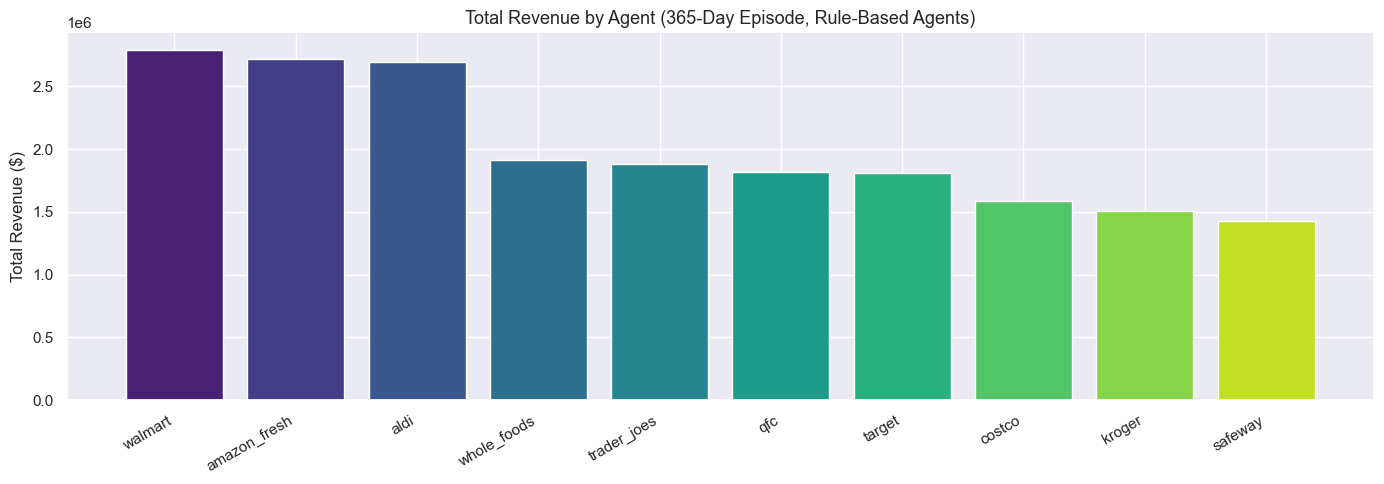

In [4]:
fig, ax = plt.subplots()
agent_revenue = df.groupby('agent')['revenue'].sum().sort_values(ascending=False)
colors = sns.color_palette("viridis", len(agent_revenue))
bars = ax.bar(agent_revenue.index, agent_revenue.values, color=colors)
ax.set_title("Total Revenue by Agent (365-Day Episode, Rule-Based Agents)", fontsize=13)
ax.set_ylabel("Total Revenue ($)")
ax.set_xlabel("")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig("../docs/validation_revenue_by_agent.png", dpi=150)
plt.show()

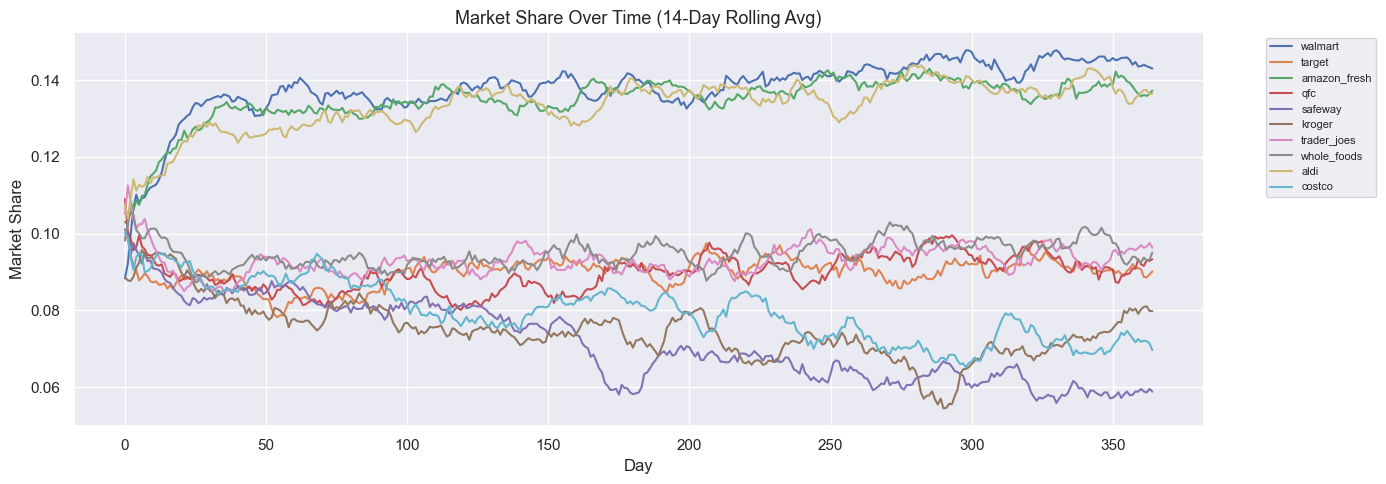

In [5]:
fig, ax = plt.subplots()
for agent_name in env2.AGENT_NAMES:
    agent_df = df[df['agent'] == agent_name]
    # smooth with 14-day rolling average
    rolling = agent_df['market_share'].rolling(14, min_periods=1).mean()
    ax.plot(agent_df['day'], rolling, label=agent_name, linewidth=1.5)

ax.set_title("Market Share Over Time (14-Day Rolling Avg)", fontsize=13)
ax.set_ylabel("Market Share")
ax.set_xlabel("Day")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig("../docs/validation_market_share.png", dpi=150)
plt.show()

2026-03-01 17:11:36 | INFO     | environment.promotions | PromotionCalendar initialized | 11 promo windows | weekend_multiplier=1.347


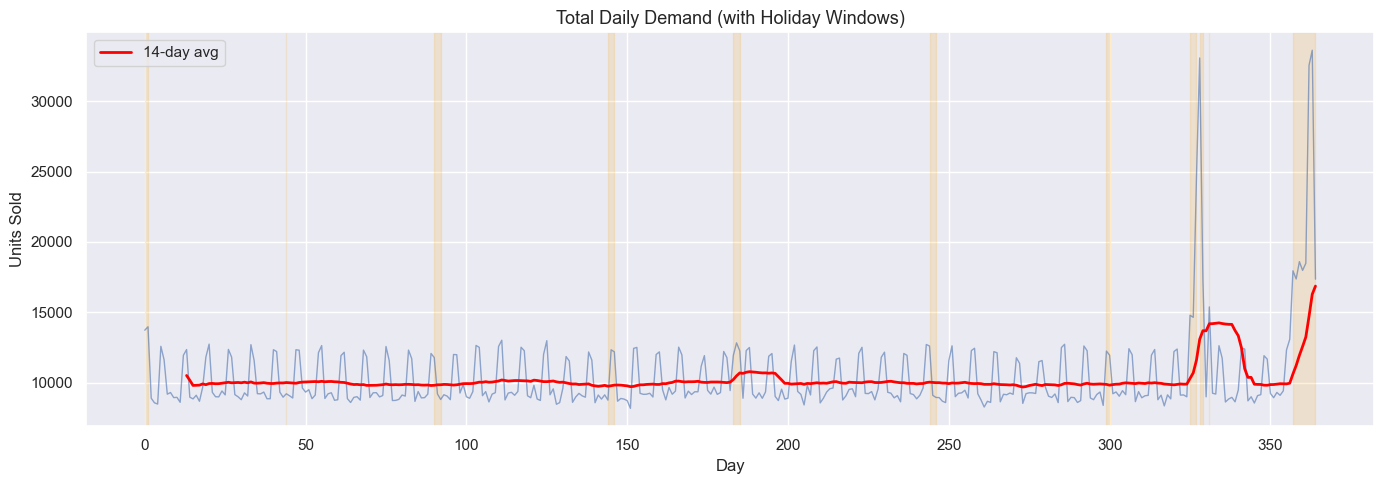

In [6]:
daily_demand = df.groupby('day')['total_demand'].first()

fig, ax = plt.subplots()
ax.plot(daily_demand.index, daily_demand.values, linewidth=1, alpha=0.6)
ax.plot(daily_demand.index,
        pd.Series(daily_demand.values).rolling(14).mean(),
        linewidth=2, color='red', label='14-day avg')

# mark holidays
from environment.promotions import PromotionCalendar
cal = PromotionCalendar()
for window in cal.promo_windows:
    ax.axvspan(window.start_day, window.end_day,
               alpha=0.15, color='orange', label='_nolegend_')

ax.set_title("Total Daily Demand (with Holiday Windows)", fontsize=13)
ax.set_ylabel("Units Sold")
ax.set_xlabel("Day")
ax.legend()
plt.tight_layout()
plt.savefig("../docs/validation_daily_demand.png", dpi=150)
plt.show()

In [7]:
print("=" * 55)
print("ENVIRONMENT VALIDATION SUMMARY")
print("=" * 55)
print(f"Episode length:       {df['day'].nunique()} days")
print(f"Total agents:         {df['agent'].nunique()}")
print(f"Avg daily demand:     {daily_demand.mean():.0f} units")
print(f"Peak daily demand:    {daily_demand.max():.0f} units (day {daily_demand.idxmax()})")
print(f"Min daily demand:     {daily_demand.min():.0f} units (day {daily_demand.idxmin()})")
print()
print("Revenue ranking:")
for i, (agent, rev) in enumerate(agent_revenue.items(), 1):
    share = df[df['agent']==agent]['market_share'].mean()
    print(f"  {i:2}. {agent:<15} ${rev:>12,.0f}  avg_share={share:.1%}")
print("=" * 55)

ENVIRONMENT VALIDATION SUMMARY
Episode length:       365 days
Total agents:         10
Avg daily demand:     10424 units
Peak daily demand:    33624 units (day 363)
Min daily demand:     8179 units (day 151)

Revenue ranking:
   1. walmart         $   2,790,340  avg_share=13.9%
   2. amazon_fresh    $   2,719,755  avg_share=13.5%
   3. aldi            $   2,694,167  avg_share=13.4%
   4. whole_foods     $   1,914,212  avg_share=9.5%
   5. trader_joes     $   1,877,519  avg_share=9.3%
   6. qfc             $   1,813,437  avg_share=9.0%
   7. target          $   1,809,574  avg_share=9.0%
   8. costco          $   1,585,452  avg_share=7.9%
   9. kroger          $   1,507,889  avg_share=7.5%
  10. safeway         $   1,424,522  avg_share=7.1%
